<a href="https://colab.research.google.com/github/Ugo5738/Natural_language_processing_projects/blob/main/Deploying_Sentiment_Analysis_Transfer_Learning_with_Tensorflow_Serving(tweets_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue May 11 12:42:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Install dependencies

In [2]:
try:
    %tensorflow_version 2.x
except:
    pass

In [3]:
import os
import json
import tempfile
import requests

import re
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split 

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pathlib
import shutil
import tempfile

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display

!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

print("\u2022 using Tensorflow version:", tf.__version__)

     |████████████████████████████████| 1.0MB 7.7MB/s 
Version:  2.4.1
Hub version:  0.12.0
GPU is available
• using Tensorflow version: 2.4.1


# Handling Dataset

## Download Dataset from Kaggle

In [4]:
!pip install --quiet kaggle

# upload the kaggle.json file from your local system
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ugochukwunwachukwu","key":"bf40d33f01a1437a69ae5fb2505e2f7e"}'}

In [5]:
# make the /.kaggle directory
!mkdir -p ~/.kaggle

# copy the kaggle.json file into the /.kaggle directory
!cp kaggle.json ~/.kaggle
# check the files in the /.kaggle directory

!ls /root/.kaggle/
# check the file permission 

!ls -l ~/.kaggle/kaggle.json
# change file permission
# chmod 600 - owner can write and read
# chmod 700 - owner can write, read and execute

!chmod 600 ~/.kaggle/kaggle.json

kaggle.json
-rw-r--r-- 1 root root 74 May 11 12:45 /root/.kaggle/kaggle.json


In [6]:
!kaggle datasets list -s 'Sentiment140 dataset with 1.6 million tweets'

ref                                                    title                                          size  lastUpdated          downloadCount  
-----------------------------------------------------  --------------------------------------------  -----  -------------------  -------------  
kazanova/sentiment140                                  Sentiment140 dataset with 1.6 million tweets   81MB  2017-09-13 22:43:19          54921  
raohammas/sentimental-analysis-trained-model-on-mlnet  Sentimental Analysis trained Model on ML.Net  120MB  2020-10-28 18:25:53             12  
grwche/sentiment                                       Sentiment                                       2GB  2020-04-23 23:29:23            137  
malikhasan/16-million-sentiment-tweets                 1.6 million sentiment tweets                   81MB  2020-04-14 22:54:15             16  


In [7]:
!kaggle datasets download -d kazanova/sentiment140 

 69% 56.0M/80.9M [00:00<00:00, 72.9MB/s]
100% 80.9M/80.9M [00:00<00:00, 92.7MB/s]


## Data Wrangling

In [8]:
df = pd.read_csv('/content/sentiment140.zip', 
                 encoding = 'ISO-8859-1',
                 names = ['target','id','date','flag','user','text'],
                 compression='zip', # decompress this zip file
                 low_memory=False)

df = df[['text', 'target']]
df = df.sample(frac=1).reset_index(drop=True)

df.shape

(1600000, 2)

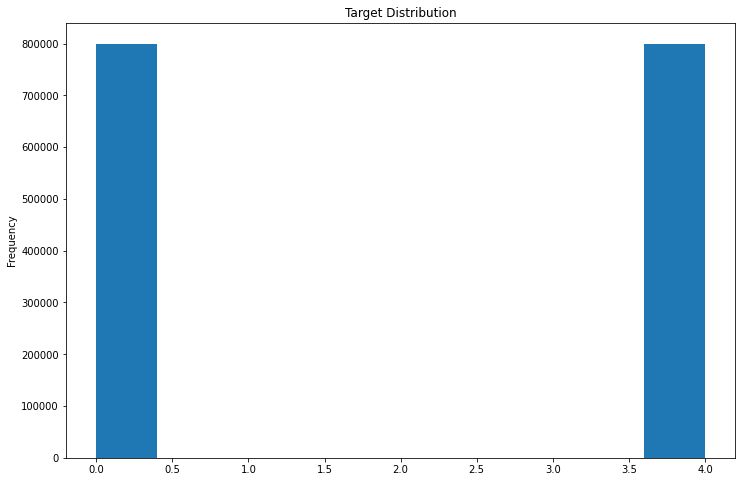

In [9]:
df['target'].plot(kind='hist', title='Target Distribution')

In [10]:
df.text.head(15).values

array(["so sick!   got the flu  ! had lots and lots of ice cream at @nehajb 's house!",
       'wiii, i can tweet, i cam tweet! i have to wait one hour  i was tweetless',
       "@tokiohotelusa did they have a video acceptance speech or anything? I can't watch the stream ",
       '@simontay78 Yes I agree! Live life with no regrets ',
       'http://twitpic.com/6b87g - Say hello to beatriz ',
       "@jakks i'm sorry for your loss.  ",
       "I'm craving some good old fashion Kraft Mac n' Cheese out of the Box. Damn that sounds good right now ",
       '@nkotbfan4life09 same really ',
       "@hangloose03 NOOOOOOO...! I'm dieingggg over hereeee.     okay.. but dont take to long.",
       'laying across my bed... hurt my back a few days ago ',
       'hey everybody i miss my best friends chanel,jaylynn,alania, amber i love you ',
       "@mzshakira tell me about it.  so what's good with that interview? is it really airing tonight?",
       'eating breakfast but there is nothing in ',
 

In [11]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9,.']+"
# TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

"""
nltk.download('stopwords')

stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")


def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)
"""
# try this preprocessing and try to retain the stopwords
def preprocess(text, stem=False):
    # Remove link, user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text)).strip()
    tokens = []
    for token in text.split():
        tokens.append(token)

    return " ".join(tokens)

df.text = df.text.apply(lambda x: preprocess(x))

In [12]:
df.text.head(15).values

array(["so sick got the flu had lots and lots of ice cream at nehajb 's house",
       'wiii, i can tweet, i cam tweet i have to wait one hour i was tweetless',
       "did they have a video acceptance speech or anything I can't watch the stream",
       'Yes I agree Live life with no regrets', 'Say hello to beatriz',
       "i'm sorry for your loss.",
       "I'm craving some good old fashion Kraft Mac n' Cheese out of the Box. Damn that sounds good right now",
       'same really',
       "NOOOOOOO... I'm dieingggg over hereeee. okay.. but dont take to long.",
       'laying across my bed... hurt my back a few days ago',
       'hey everybody i miss my best friends chanel,jaylynn,alania, amber i love you',
       "tell me about it. so what's good with that interview is it really airing tonight",
       'eating breakfast but there is nothing in',
       'About to loose at monopoly with Peter', 'sorry I feel mean'],
      dtype=object)

In [13]:
df.target.tail(15).values

array([4, 4, 0, 0, 4, 4, 4, 0, 0, 4, 4, 0, 4, 4, 4])

In [14]:
for index, value in enumerate(df.target.values):
    df.target.values[index] = 1 if (value == 4) else 0
        
df.target.tail(15).values

array([1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1])

In [15]:
train_df, remaining = train_test_split(df, random_state=42, train_size=0.2, stratify=df.target.values) # stratify parameter will preserve the proportion of target as in original dataset, in the train and test datasets as well.
test_df, _ = train_test_split(remaining, random_state=42, train_size=0.07, stratify=remaining.target.values)
train_df.shape, test_df.shape

((320000, 2), (89600, 2))

# Building and Training Models

In [16]:
def train_and_evaluate_model(module_url, embed_size, name, trainable=False):
    hub_layer = hub.KerasLayer(module_url, output_shape=[embed_size], input_shape=[], dtype=tf.string, trainable=trainable)
    model = tf.keras.models.Sequential([hub_layer, # this would generate a fixed length output vector
                                        tf.keras.layers.Dense(256, activation='relu'),
                                        tf.keras.layers.Dense(64, activation='relu'),
                                        tf.keras.layers.Dense(1, activation='sigmoid')
                                        ])

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                  loss=tf.losses.BinaryCrossentropy(),
                  metrics=[tf.metrics.BinaryAccuracy(name='accuracy')]) # accuracy is not the best metric to use here because of the class imbalance. However, BinaryAccuracy calculates how often predictions match binary labels.
                  # the name parameter makes it easier for us to call the metrics for plotting

    model.summary()
    
    history = model.fit(train_df['text'], train_df['target'],
                        epochs=1,
                        batch_size=32,
                        validation_data=(test_df['text'], test_df['target']),
                        # validation_split=0.2,
                        verbose=1,
                        callbacks=[tfdocs.modeling.EpochDots(), # after an epoch is complete, it'll append a dot to a sequence so that the screen looks much more readable
                                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min'), # we are monitoring the validation loss and if after 2 consecutive epochs the validation doesn't improve then we will stop training. The mode is minimum because we are minizing the loss.
                                  tf.keras.callbacks.TensorBoard(logdir/name)] # specify that we want to log all the metrics in the log directory within a subdirectory given be the name of model.
                        )
    return history, model

## Train Various Text Classification Models

In [17]:
histories = {}

In [18]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [19]:
histories['universal-sentence-encoder-large-finetuned'], model = train_and_evaluate_model(module_url, embed_size=512, name='universal-sentence-encoder-large-finetuned', trainable=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               147354880 
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 147,502,721
Trainable params: 147,502,721
Non-trainable params: 0
_________________________________________________________________


    6/10000 [..............................] - ETA: 2:18:32 - loss: 0.6901 - accuracy: 0.5685WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1441s vs `on_train_batch_end` time: 0.5466s). Check your callbacks.


10000/10000 [==============================] - 1747s 169ms/step - loss: 0.3904 - accuracy: 0.8256 - val_loss: 0.3572 - val_accuracy: 0.8440

Epoch: 0, accuracy:0.8356,  loss:0.3694,  val_accuracy:0.8440,  val_loss:0.3572,  
.

I tested all pretrained embeddings and found that the finetuned universal-sentence-encoder-large performed best on this dataset. Although, after epoch 1, it began to overfit.

# Test model

In [24]:
sentences = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible...",
  "It's a crazy idea but for some reason I like it and I think it'll could work",
  "It's a nice idea but for some reason I don't like it and I don't think it can work"
]

prediction = model.predict(sentences)
print(prediction)

[[0.9937511 ]
 [0.5865681 ]
 [0.0456425 ]
 [0.990931  ]
 [0.20380327]]


# Save the Model

In [25]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key

MODEL_DIR = tempfile.gettempdir()

version = 1

export_path = os.path.join(MODEL_DIR, str(version))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

# This is the actual code for saving the model
model.save(export_path, save_format="tf")

print('Saved model to export_path = {}\n'.format(export_path))
!ls -l {export_path}

INFO:tensorflow:Assets written to: /tmp/1/assets


INFO:tensorflow:Assets written to: /tmp/1/assets


Saved model to export_path = /tmp/1

total 38728
drwxr-xr-x 2 root root     4096 May 11 13:20 assets
-rw-r--r-- 1 root root 39647416 May 11 13:20 saved_model.pb
drwxr-xr-x 2 root root     4096 May 11 13:20 variables


## Examine Model

In [26]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['keras_layer_input'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: serving_default_keras_layer_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_2'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: StatefulPartitionedCall_1:0
  Method name is: tensorflow/serving/predict
W0511 13:20:59.748996 140611293554560 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/py

# Tensorflow Serving

## Add Tensorflow Serving Distribution Url as a Package Source

In [27]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  21021      0 --:--:-- --:--:-- --:--:-- 21172
OK
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1

In [28]:
# Install Tensorflow Serving

!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 58 not upgraded.
Need to get 326 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.5.0 [326 MB]
Fetched 326 MB in 4s (73.9 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.5.0_all.deb ...
Unpacking tensorflow-model-server (2.5.0) ...
Setting up tensorflow-model-server (2.5.0) ...


# Tensorflow Model Server

## Run the Tensorflow Model Server

In [29]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [30]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=helloworld \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [31]:
# Viewing Server log

!tail server.log

2021-05-11 13:22:05.362079: I tensorflow_serving/model_servers/server.cc:89] Building single TensorFlow model file config:  model_name: helloworld model_base_path: /tmp
2021-05-11 13:22:05.362394: I tensorflow_serving/model_servers/server_core.cc:465] Adding/updating models.
2021-05-11 13:22:05.362432: I tensorflow_serving/model_servers/server_core.cc:591]  (Re-)adding model: helloworld
2021-05-11 13:22:05.364732: I tensorflow_serving/core/basic_manager.cc:740] Successfully reserved resources to load servable {name: helloworld version: 1}
2021-05-11 13:22:05.364775: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: helloworld version: 1}
2021-05-11 13:22:05.364789: I tensorflow_serving/core/loader_harness.cc:74] Loading servable version {name: helloworld version: 1}
2021-05-11 13:22:05.364837: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: /tmp/1


# Create JSON Object with Test Data

In [33]:
sentence = ["What a stupid thing to say and at the same time it is quite amazing to see that you can be honest in a time such as this!"]
# sequence = tokenizer.texts_to_sequences(sentence)
# test_sentence = pad_sequences(sequence, maxlen=max_length, truncating=trunk_type)

data = json.dumps({"signature_name": "serving_default", "instances": sentence})
print(data)

{"signature_name": "serving_default", "instances": ["What a stupid thing to say and at the same time it is quite amazing to see that you can be honest in a time such as this!"]}


# Make Inference Request

In [34]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/helloworld:predict', data=data, headers=headers)

print(json_response.text)

{
    "predictions": [[0.929793537]
    ]
}


In [35]:
prediction = json.loads(json_response.text)['predictions']
prediction = float(prediction[0][0])
print(prediction)

0.929793537


In [36]:
if prediction > 0.5:
    print("This comment is positive")
elif prediction == 0.5:
    print("This comment is neutral")
else:
    print("This commment is negative")

This comment is positive
